In [1]:
import os
import numpy as np
import glob
import cv2
import random
import pathlib
import matplotlib.pyplot as plt
from pprint import pprint
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from PIL import Image

In [2]:
from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
!nvidia-smi

Mon Apr 11 11:05:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.47       Driver Version: 472.47       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0    24W /  N/A |    121MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
lr = 1e-4
batch_size = 32
img_height = 256
img_width = 256
pin_memory = True

train_img_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/train/images'
train_mask_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/train/mask'
val_img_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/test/images'
val_mask_dir = r'C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/test/mask'

In [6]:
# dataset source: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification

class ISDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform, mask_transform):
        super(ISDataset, self)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.img = os.listdir(img_dir)
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img[index])
        mask_path = os.path.join(self.mask_dir, self.img[index].replace('.jpg', '_mask.png'))
        img = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))
        
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
            
        return img, mask

In [7]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0, 0, 0], [1, 1, 1]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0], [1]),
])

train_ds = ISDataset(
    img_dir=train_img_dir,
    mask_dir=train_mask_dir,
    img_transform=img_transform,
    mask_transform=mask_transform
)

val_ds = ISDataset(
    img_dir=val_img_dir,
    mask_dir=val_mask_dir,
    img_transform=img_transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    pin_memory=pin_memory,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    pin_memory=pin_memory,
    shuffle=False
)

In [8]:
def bottleneck(in_c, out_c, regular=False, dilated=False, dilation=None, asymm=False, down_sampling=False, up_sampling=False):
    if down_sampling:
        conv = nn.Sequential(
            nn.Conv2d(in_c, in_c//2, kernel_size=(2, 2), stride=2),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),  
            nn.Conv2d(in_c//2, in_c//2, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, in_c*(out_c//in_c-1), kernel_size=(1, 1)),
            nn.BatchNorm2d(in_c*(out_c//in_c-1))
        )
        conv1 = nn.Sequential(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), return_indices=True))
        
        return conv, conv1
        
    if up_sampling:
        conv = nn.Sequential(
            nn.ConvTranspose2d(in_c, in_c//2, kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, in_c//2, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, out_c, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_c)
        )
        conv1 = nn.Sequential(nn.MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2)))
        return conv#, conv1
        
    elif regular:
        conv = nn.Sequential(
            nn.Conv2d(in_c, in_c//2, kernel_size=(1, 1)),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, in_c//2, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, out_c, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_c)
        )
        return conv
    elif dilated:
        conv = nn.Sequential(
            nn.Conv2d(in_c, in_c//2, kernel_size=(1, 1)),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, in_c//2, kernel_size=(3, 3), dilation=dilation, padding=dilation),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, out_c, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_c)
        )
        return conv
        
    elif asymm:
        conv = nn.Sequential(
            nn.Conv2d(in_c, in_c//2, kernel_size=(1, 1)),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d (in_c//2, in_c//2, (1, 5), bias = False, padding=(0, 2)),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d (in_c//2, in_c//2, (5, 1), bias = False, padding=(2, 0)),
            nn.BatchNorm2d(in_c//2),
            nn.PReLU(),
            nn.Conv2d(in_c//2, out_c, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_c)
        )
        return conv


In [9]:
def conv1x1(in_c, out_c):
    conv = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=(1, 1)))
    return conv

In [10]:
class ENET(nn.Module):
    def __init__(self):
        super(ENET, self).__init__()
        
        self.initial1 = nn.Conv2d(3, 13, kernel_size=(3, 3), stride=2, padding=1)
        self.initial2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bn10_1, self.bn10_2 = bottleneck(16, 64, down_sampling=True)   ### 2
        self.conv1x1_10 = conv1x1(64, 64)
        self.bn11 = bottleneck(64, 64, regular=True)
        self.conv1x1_11 = conv1x1(128, 64)
        self.bn12 = bottleneck(64, 64, regular=True)
        self.conv1x1_12 = conv1x1(128, 64)
        self.bn13 = bottleneck(64, 64, regular=True)
        self.conv1x1_13 = conv1x1(128, 64)
        self.bn14 = bottleneck(64, 64, regular=True)
        self.conv1x1_14 = conv1x1(128, 64)
        
        self.bn20_1, self.bn20_2 = bottleneck(64, 128, down_sampling=True)  ### 2
        self.conv1x1_20 = conv1x1(128, 128)
        self.bn21 = bottleneck(128, 128, regular=True)
        self.conv1x1_21 = conv1x1(256, 128)
        self.bn22 = bottleneck(128, 128, dilated=True, dilation=2)
        self.conv1x1_22 = conv1x1(256, 128)
        self.bn23 = bottleneck(128, 128, asymm=True)
        self.conv1x1_23 = conv1x1(256, 128)
        self.bn24 = bottleneck(128, 128, dilated=True, dilation=4)
        self.conv1x1_24 = conv1x1(256, 128)
        self.bn25 = bottleneck(128, 128, regular=True)
        self.conv1x1_25 = conv1x1(256, 128)
        self.bn26 = bottleneck(128, 128, dilated=True, dilation=8)
        self.conv1x1_26 = conv1x1(256, 128)
        self.bn27 = bottleneck(128, 128, asymm=True)
        self.conv1x1_27 = conv1x1(256, 128)
        self.bn28 = bottleneck(128, 128, dilated=True, dilation=8)
        self.conv1x1_28 = conv1x1(256, 128)

        self.bn31 = bottleneck(128, 128, regular=True)
        self.conv1x1_31 = conv1x1(256, 128)
        self.bn32 = bottleneck(128, 128, dilated=True, dilation=2)
        self.conv1x1_32 = conv1x1(256, 128)
        self.bn33 = bottleneck(128, 128, asymm=True)
        self.conv1x1_33 = conv1x1(256, 128)
        self.bn34 = bottleneck(128, 128, dilated=True, dilation=4)
        self.conv1x1_34 = conv1x1(256, 128)
        self.bn35 = bottleneck(128, 128, regular=True)
        self.conv1x1_35 = conv1x1(256, 128)
        self.bn36 = bottleneck(128, 128, dilated=True, dilation=8)
        self.conv1x1_36 = conv1x1(256, 128)
        self.bn37 = bottleneck(128, 128, asymm=True)
        self.conv1x1_37 = conv1x1(256, 128)
        self.bn38 = bottleneck(128, 128, dilated=True, dilation=8)
        self.conv1x1_38 = conv1x1(256, 128)
        
        self.bn40_1 = bottleneck(128, 64, up_sampling=True) # , self.bn40_2
        self.conv1x1_40 = conv1x1(64, 64)
        self.bn41 = bottleneck(64, 64, regular=True)
        self.conv1x1_41 = conv1x1(128, 64)
        self.bn42 = bottleneck(64, 64, regular=True)
        self.conv1x1_42 = conv1x1(128, 64)
        
        self.bn50_1 = bottleneck(64, 16, up_sampling=True) # , self.bn50_2
        self.conv1x1_50 = conv1x1(16, 16)
        self.bn51 = bottleneck(16, 16, regular=True)
        self.conv1x1_51 = conv1x1(32, 16)
        
        self.out = nn.ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
        
    def forward(self, img):
        x_i1 = self.initial1(img)
        x_i2 = self.initial2(img)
        #print(x_i1.shape, x_i2.shape)
        x_i = torch.concat([x_i1, x_i2], 1)
        
        x10_1 = self.bn10_1(x_i)
        x10_2, indices_10 = self.bn10_2(x_i)      # maxpooling
        #print(x10_2.shape, indices_10.shape)
        x10 = self.conv1x1_10(torch.concat([x10_1, x10_2], 1))
        x = self.bn11(x10)
        x11 = self.conv1x1_11(torch.concat([x, x10], 1))
        x = self.bn12(x11)
        x12 = self.conv1x1_12(torch.concat([x, x11], 1))
        x = self.bn13(x12)
        x13 = self.conv1x1_13(torch.concat([x, x12], 1))
        x = self.bn14(x13)
        x14 = self.conv1x1_14(torch.concat([x, x13], 1))
        
        x20_1 = self.bn20_1(x14)
        x20_2, indices_20 = self.bn20_2(x14)     # maxpooling
        #print(indices_20.shape)
        x20 = self.conv1x1_20(torch.concat([x20_1, x20_2], 1))
        x = self.bn21(x20)
        x21 = self.conv1x1_21(torch.concat([x, x20], 1))
        x = self.bn22(x21)
        #print(x.shape, x21.shape)
        x22 = self.conv1x1_22(torch.concat([x, x21], 1))
        x = self.bn23(x22)
        #print(x.shape, x22.shape)
        x23 = self.conv1x1_23(torch.concat([x, x22], 1))
        x = self.bn24(x23)
        x24 = self.conv1x1_24(torch.concat([x, x23], 1))
        x = self.bn25(x24)
        x25 = self.conv1x1_25(torch.concat([x, x24], 1))
        x = self.bn26(x25)
        x26 = self.conv1x1_26(torch.concat([x, x25], 1))
        x = self.bn27(x26)
        x27 = self.conv1x1_27(torch.concat([x, x26], 1))
        x = self.bn28(x27)
        x28 = self.conv1x1_28(torch.concat([x, x27], 1))
        
        x = self.bn31(x28)
        x31 = self.conv1x1_31(torch.concat([x, x28], 1))
        x = self.bn32(x31)
        x32 = self.conv1x1_32(torch.concat([x, x31], 1))
        x = self.bn33(x32)
        x33 = self.conv1x1_33(torch.concat([x, x32], 1))
        x = self.bn34(x33)
        x34 = self.conv1x1_34(torch.concat([x, x33], 1))
        x = self.bn35(x34)
        x35 = self.conv1x1_35(torch.concat([x, x34], 1))
        x = self.bn36(x35)
        x36 = self.conv1x1_36(torch.concat([x, x35], 1))
        x = self.bn37(x36)
        x37 = self.conv1x1_37(torch.concat([x, x36], 1))
        x = self.bn38(x37)
        x38 = self.conv1x1_38(torch.concat([x, x37], 1))
        
        x40_1 = self.bn40_1(x38)
        #print(x40_1.shape)
        x40_1 = self.conv1x1_40(x40_1)
        #print(indices_20)
        #x40_2 = self.bn40_2(x38)   # add x38
        #x40 = self.conv1x1_40(torch.concat([x40_1, x40_2], 1))
        x = self.bn41(x40_1)
        x41 = self.conv1x1_41(torch.concat([x, x40_1], 1))
        x = self.bn42(x41)
        x42 = self.conv1x1_42(torch.concat([x, x41], 1))
        
        x50_1 = self.bn50_1(x42)
        #print(x50_1.shape, x42.shape)
        x50_1 = self.conv1x1_50(x50_1)
        #print(x50_1.shape)
        #x50_2 = self.bn50_2(x42)
        #x50 = self.conv1x1_50(torch.concat([x50_1, x50_2], 1))
        x = self.bn51(x50_1)
        x51 = self.conv1x1_51(torch.concat([x, x50_1], 1))
        
        x_out = self.out(x51)
        return x_out
        

In [11]:
model = ENET()
print(model)

ENET(
  (initial1): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (initial2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn10_1): Sequential(
    (0): Conv2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Conv2d(8, 48, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn10_2): Sequential(
    (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv1x1_10): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (bn11): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1),

In [12]:
pprint(torchinfo.summary(model, input_size=(1, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
ENET                                     --                        --
├─Conv2d: 1-1                            [1, 13, 128, 128]         364
├─MaxPool2d: 1-2                         [1, 3, 128, 128]          --
├─Sequential: 1-3                        [1, 48, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            520
│    └─BatchNorm2d: 2-2                  [1, 8, 64, 64]            16
│    └─PReLU: 2-3                        [1, 8, 64, 64]            1
│    └─Conv2d: 2-4                       [1, 8, 64, 64]            584
│    └─BatchNorm2d: 2-5                  [1, 8, 64, 64]            16
│    └─PReLU: 2-6                        [1, 8, 64, 64]            1
│    └─Conv2d: 2-7                       [1, 48, 64, 64]           432
│    └─BatchNorm2d: 2-8                  [1, 48, 64, 64]           96
├─Sequential: 1-4                        [1, 16, 64, 64]           --
│    └─MaxPoo

C:\Users\utkar\miniconda3\envs\torch\lib\site-packages\torch\nn\functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [13]:
x = torch.rand((1, 3, 512, 512))
y = model(x.to(device))
print(y.shape)

torch.Size([1, 1, 512, 512])


In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
def check_acc(loader, model, device='cuda'):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)   # returns product of the values in tensor
            dice_score += (2*(preds*y).sum())/((preds + y).sum()+1e-8)
            
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
            

In [16]:
scaler = torch.cuda.amp.GradScaler()   # to avoid vanishing gradient problem

In [17]:
epochs = 5

for epoch in range(epochs):
    # training
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        target = targets.float().to(device)
        
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, target)
        
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        # checcking accuracy
        check_acc(val_loader, model, device=device)
    print(f'epoch {epoch}')
        

  0%|▎                                                                   | 1/251 [00:22<1:34:53, 22.77s/it, loss=0.734]

Got 49531419/131072000 with acc 37.79
Dice score: 0.38559120893478394


  1%|▌                                                                   | 2/251 [00:45<1:35:07, 22.92s/it, loss=0.729]

Got 49531419/131072000 with acc 37.79
Dice score: 0.38559120893478394


  1%|▊                                                                   | 3/251 [01:08<1:34:43, 22.92s/it, loss=0.726]

Got 57694416/131072000 with acc 44.02
Dice score: 0.3674197793006897


  2%|█                                                                   | 4/251 [01:31<1:34:24, 22.93s/it, loss=0.719]

Got 65253656/131072000 with acc 49.78
Dice score: 0.3413020372390747


  2%|█▎                                                                  | 5/251 [01:54<1:33:09, 22.72s/it, loss=0.723]

Got 65253656/131072000 with acc 49.78
Dice score: 0.3413020372390747


  2%|█▋                                                                  | 6/251 [02:15<1:31:13, 22.34s/it, loss=0.717]

Got 65130414/131072000 with acc 49.69
Dice score: 0.3409131169319153


  3%|█▉                                                                  | 7/251 [02:37<1:29:36, 22.04s/it, loss=0.712]

Got 65009154/131072000 with acc 49.60
Dice score: 0.3405318260192871


  3%|██▏                                                                 | 8/251 [02:59<1:29:33, 22.11s/it, loss=0.702]

Got 64893288/131072000 with acc 49.51
Dice score: 0.34017878770828247


  4%|██▍                                                                 | 9/251 [03:21<1:29:48, 22.26s/it, loss=0.687]

Got 61320995/131072000 with acc 46.78
Dice score: 0.3548605740070343


  4%|██▋                                                                | 10/251 [03:45<1:30:57, 22.64s/it, loss=0.693]

Got 59581981/131072000 with acc 45.46
Dice score: 0.3615741431713104


  4%|██▉                                                                | 11/251 [04:08<1:30:34, 22.64s/it, loss=0.682]

Got 57632488/131072000 with acc 43.97
Dice score: 0.36723822355270386


  5%|███▏                                                               | 12/251 [04:30<1:30:09, 22.63s/it, loss=0.663]

Got 57632488/131072000 with acc 43.97
Dice score: 0.36723822355270386


  5%|███▌                                                                | 13/251 [04:53<1:29:30, 22.56s/it, loss=0.67]

Got 57573862/131072000 with acc 43.93
Dice score: 0.36707112193107605


  6%|███▋                                                               | 14/251 [05:15<1:28:42, 22.46s/it, loss=0.668]

Got 57513271/131072000 with acc 43.88
Dice score: 0.36689820885658264


  6%|████                                                               | 15/251 [05:37<1:28:05, 22.40s/it, loss=0.651]

Got 57509325/131072000 with acc 43.88
Dice score: 0.3668859899044037


  6%|████▎                                                              | 16/251 [05:59<1:27:42, 22.39s/it, loss=0.652]

Got 57511297/131072000 with acc 43.88
Dice score: 0.3668920695781708


  7%|████▌                                                              | 17/251 [06:22<1:27:13, 22.37s/it, loss=0.643]

Got 57397128/131072000 with acc 43.79
Dice score: 0.3665745258331299


  7%|████▊                                                              | 18/251 [06:44<1:26:32, 22.29s/it, loss=0.634]

Got 57397130/131072000 with acc 43.79
Dice score: 0.3665745258331299


  8%|█████                                                              | 19/251 [07:05<1:25:06, 22.01s/it, loss=0.642]

Got 57454757/131072000 with acc 43.83
Dice score: 0.3667328655719757


  8%|█████▎                                                             | 20/251 [07:26<1:23:55, 21.80s/it, loss=0.621]

Got 57510414/131072000 with acc 43.88
Dice score: 0.36688530445098877


  8%|█████▌                                                             | 21/251 [07:48<1:23:01, 21.66s/it, loss=0.627]

Got 61174028/131072000 with acc 46.67
Dice score: 0.354435533285141


  9%|█████▊                                                             | 22/251 [08:09<1:22:20, 21.57s/it, loss=0.627]

Got 66920630/131072000 with acc 51.06
Dice score: 0.33698537945747375


  9%|██████▏                                                             | 23/251 [08:31<1:22:09, 21.62s/it, loss=0.62]

Got 75069655/131072000 with acc 57.27
Dice score: 0.2884885370731354


 10%|██████▍                                                            | 24/251 [08:54<1:23:57, 22.19s/it, loss=0.602]

Got 75588024/131072000 with acc 57.67
Dice score: 0.2782757580280304


 10%|██████▋                                                            | 25/251 [09:18<1:24:56, 22.55s/it, loss=0.608]

Got 79169036/131072000 with acc 60.40
Dice score: 0.2623019516468048


 10%|██████▉                                                            | 26/251 [09:40<1:24:34, 22.55s/it, loss=0.606]

Got 79403388/131072000 with acc 60.58
Dice score: 0.24998901784420013


 11%|███████▏                                                           | 27/251 [10:03<1:24:16, 22.57s/it, loss=0.606]

Got 79093198/131072000 with acc 60.34
Dice score: 0.2517838776111603


 11%|███████▍                                                           | 28/251 [10:25<1:23:28, 22.46s/it, loss=0.616]

Got 79531850/131072000 with acc 60.68
Dice score: 0.25439584255218506


 12%|███████▋                                                           | 29/251 [10:48<1:23:06, 22.46s/it, loss=0.598]

Got 80048935/131072000 with acc 61.07
Dice score: 0.25371792912483215


 12%|████████                                                           | 30/251 [11:10<1:23:03, 22.55s/it, loss=0.585]

Got 82491406/131072000 with acc 62.94
Dice score: 0.25575318932533264


 12%|████████▍                                                           | 31/251 [11:33<1:22:43, 22.56s/it, loss=0.59]

Got 84261863/131072000 with acc 64.29
Dice score: 0.24927958846092224


 13%|████████▌                                                          | 32/251 [11:56<1:22:22, 22.57s/it, loss=0.587]

Got 85156399/131072000 with acc 64.97
Dice score: 0.24173952639102936


 13%|████████▉                                                           | 33/251 [12:18<1:21:54, 22.54s/it, loss=0.59]

Got 85795857/131072000 with acc 65.46
Dice score: 0.24990740418434143


 14%|█████████                                                          | 34/251 [12:41<1:21:34, 22.56s/it, loss=0.585]

Got 86053280/131072000 with acc 65.65
Dice score: 0.2497563660144806


 14%|█████████▍                                                          | 35/251 [13:03<1:21:04, 22.52s/it, loss=0.57]

Got 86624393/131072000 with acc 66.09
Dice score: 0.24692215025424957


 14%|█████████▌                                                         | 36/251 [13:25<1:20:24, 22.44s/it, loss=0.578]

Got 86412100/131072000 with acc 65.93
Dice score: 0.21140998601913452


 15%|█████████▉                                                         | 37/251 [13:48<1:20:05, 22.45s/it, loss=0.591]

Got 87484820/131072000 with acc 66.75
Dice score: 0.20381000638008118


 15%|██████████▏                                                        | 38/251 [14:10<1:19:48, 22.48s/it, loss=0.564]

Got 91091266/131072000 with acc 69.50
Dice score: 0.25989803671836853


 16%|██████████▍                                                        | 39/251 [14:33<1:19:37, 22.54s/it, loss=0.551]

Got 93657846/131072000 with acc 71.46
Dice score: 0.31143075227737427


 16%|██████████▋                                                        | 40/251 [14:57<1:20:42, 22.95s/it, loss=0.558]

Got 96053143/131072000 with acc 73.28
Dice score: 0.36814171075820923


 16%|██████████▉                                                        | 41/251 [15:19<1:19:40, 22.76s/it, loss=0.561]

Got 98675597/131072000 with acc 75.28
Dice score: 0.44220414757728577


 17%|███████████▏                                                       | 42/251 [15:42<1:18:56, 22.66s/it, loss=0.553]

Got 100573361/131072000 with acc 76.73
Dice score: 0.4894620180130005


 17%|███████████▍                                                       | 43/251 [16:04<1:18:19, 22.59s/it, loss=0.548]

Got 102662665/131072000 with acc 78.33
Dice score: 0.5502177476882935


 18%|███████████▋                                                       | 44/251 [16:27<1:18:05, 22.64s/it, loss=0.549]

Got 103963382/131072000 with acc 79.32
Dice score: 0.5938805341720581


 18%|████████████                                                       | 45/251 [16:49<1:17:39, 22.62s/it, loss=0.559]

Got 104935900/131072000 with acc 80.06
Dice score: 0.6290479302406311


 18%|████████████▎                                                      | 46/251 [17:11<1:16:38, 22.43s/it, loss=0.539]

Got 105458953/131072000 with acc 80.46
Dice score: 0.65093594789505


 19%|████████████▌                                                      | 47/251 [17:33<1:15:24, 22.18s/it, loss=0.547]

Got 106667647/131072000 with acc 81.38
Dice score: 0.6679933071136475


 19%|████████████▊                                                      | 48/251 [17:56<1:15:41, 22.37s/it, loss=0.543]

Got 107606574/131072000 with acc 82.10
Dice score: 0.6841394305229187


 20%|█████████████▎                                                      | 49/251 [18:18<1:15:12, 22.34s/it, loss=0.52]

Got 110379825/131072000 with acc 84.21
Dice score: 0.7098130583763123


 20%|█████████████▎                                                     | 50/251 [18:41<1:15:05, 22.41s/it, loss=0.526]

Got 112443169/131072000 with acc 85.79
Dice score: 0.7271370887756348


 20%|█████████████▌                                                     | 51/251 [19:03<1:14:49, 22.45s/it, loss=0.514]

Got 113328677/131072000 with acc 86.46
Dice score: 0.7366968989372253


 21%|█████████████▉                                                     | 52/251 [19:26<1:14:25, 22.44s/it, loss=0.507]

Got 113657452/131072000 with acc 86.71
Dice score: 0.7408319711685181


 21%|██████████████▏                                                    | 53/251 [19:48<1:13:56, 22.41s/it, loss=0.513]

Got 113636976/131072000 with acc 86.70
Dice score: 0.743497371673584


 22%|██████████████▍                                                    | 54/251 [20:10<1:13:38, 22.43s/it, loss=0.506]

Got 113980125/131072000 with acc 86.96
Dice score: 0.7519309520721436


 22%|██████████████▉                                                     | 55/251 [20:33<1:13:14, 22.42s/it, loss=0.51]

Got 115012369/131072000 with acc 87.75
Dice score: 0.769959568977356


 22%|██████████████▉                                                    | 56/251 [20:56<1:13:05, 22.49s/it, loss=0.491]

Got 115598609/131072000 with acc 88.19
Dice score: 0.779775083065033


 23%|███████████████▍                                                    | 57/251 [21:18<1:12:44, 22.50s/it, loss=0.51]

Got 115402459/131072000 with acc 88.05
Dice score: 0.7828419208526611


 23%|███████████████▍                                                   | 58/251 [21:40<1:12:02, 22.39s/it, loss=0.525]

Got 115574409/131072000 with acc 88.18
Dice score: 0.7876369953155518


 24%|███████████████▋                                                   | 59/251 [22:03<1:11:45, 22.42s/it, loss=0.501]

Got 115147684/131072000 with acc 87.85
Dice score: 0.7847288250923157


 24%|████████████████▎                                                   | 60/251 [22:25<1:11:32, 22.48s/it, loss=0.49]

Got 114526958/131072000 with acc 87.38
Dice score: 0.7794653177261353


 24%|████████████████▎                                                  | 61/251 [22:48<1:11:18, 22.52s/it, loss=0.507]

Got 114091692/131072000 with acc 87.05
Dice score: 0.776411235332489


 25%|████████████████▌                                                  | 62/251 [23:10<1:10:53, 22.51s/it, loss=0.471]

Got 113333316/131072000 with acc 86.47
Dice score: 0.7704505920410156


 25%|████████████████▊                                                  | 63/251 [23:33<1:10:38, 22.54s/it, loss=0.519]

Got 113248806/131072000 with acc 86.40
Dice score: 0.7719754576683044


 25%|█████████████████                                                  | 64/251 [23:55<1:10:09, 22.51s/it, loss=0.477]

Got 114194670/131072000 with acc 87.12
Dice score: 0.7823662757873535


 26%|█████████████████▎                                                 | 65/251 [24:18<1:09:50, 22.53s/it, loss=0.464]

Got 115106770/131072000 with acc 87.82
Dice score: 0.7922403216362


 26%|█████████████████▌                                                 | 66/251 [24:40<1:09:20, 22.49s/it, loss=0.462]

Got 115864305/131072000 with acc 88.40
Dice score: 0.8009593486785889


 27%|█████████████████▉                                                 | 67/251 [25:04<1:09:45, 22.75s/it, loss=0.462]

Got 116366888/131072000 with acc 88.78
Dice score: 0.8063446283340454


 27%|██████████████████▏                                                | 68/251 [25:28<1:10:45, 23.20s/it, loss=0.446]

Got 116875890/131072000 with acc 89.17
Dice score: 0.8123995065689087


 27%|██████████████████▍                                                | 69/251 [25:50<1:08:57, 22.73s/it, loss=0.448]

Got 117094681/131072000 with acc 89.34
Dice score: 0.8166186213493347


 28%|██████████████████▋                                                | 70/251 [26:12<1:07:53, 22.50s/it, loss=0.444]

Got 117737917/131072000 with acc 89.83
Dice score: 0.8232452869415283


 28%|███████████████████▏                                                | 71/251 [26:33<1:06:26, 22.15s/it, loss=0.46]

Got 117897606/131072000 with acc 89.95
Dice score: 0.8252347707748413


 29%|███████████████████▏                                               | 72/251 [26:54<1:05:21, 21.91s/it, loss=0.458]

Got 116630639/131072000 with acc 88.98
Dice score: 0.8145315647125244


 29%|███████████████████▍                                               | 73/251 [27:16<1:04:36, 21.78s/it, loss=0.459]

Got 114215555/131072000 with acc 87.14
Dice score: 0.7921639680862427


 29%|███████████████████▊                                               | 74/251 [27:37<1:04:09, 21.75s/it, loss=0.468]

Got 114111996/131072000 with acc 87.06
Dice score: 0.7901590466499329


 30%|████████████████████                                               | 75/251 [28:00<1:04:07, 21.86s/it, loss=0.428]

Got 114961517/131072000 with acc 87.71
Dice score: 0.7966973185539246


 30%|████████████████████▎                                              | 76/251 [28:21<1:03:09, 21.66s/it, loss=0.447]

Got 116213553/131072000 with acc 88.66
Dice score: 0.8076851963996887


 31%|████████████████████▌                                              | 77/251 [28:42<1:02:29, 21.55s/it, loss=0.421]

Got 116813508/131072000 with acc 89.12
Dice score: 0.8133424520492554


 31%|████████████████████▊                                              | 78/251 [29:03<1:01:59, 21.50s/it, loss=0.428]

Got 117689998/131072000 with acc 89.79
Dice score: 0.8216671347618103


 31%|█████████████████████                                              | 79/251 [29:24<1:01:05, 21.31s/it, loss=0.439]

Got 118446689/131072000 with acc 90.37
Dice score: 0.8297658562660217


 32%|█████████████████████▋                                              | 80/251 [29:46<1:00:43, 21.30s/it, loss=0.42]

Got 118586935/131072000 with acc 90.47
Dice score: 0.8316893577575684


 32%|█████████████████████▌                                             | 81/251 [30:07<1:00:39, 21.41s/it, loss=0.419]

Got 117895822/131072000 with acc 89.95
Dice score: 0.8253592848777771


 33%|█████████████████████▉                                             | 82/251 [30:29<1:00:20, 21.42s/it, loss=0.432]

Got 117141747/131072000 with acc 89.37
Dice score: 0.8185144066810608


 33%|███████████████████████▏                                              | 83/251 [30:50<59:56, 21.41s/it, loss=0.43]

Got 116235853/131072000 with acc 88.68
Dice score: 0.8096110224723816


 33%|██████████████████████▍                                            | 84/251 [31:13<1:00:54, 21.88s/it, loss=0.427]

Got 115909670/131072000 with acc 88.43
Dice score: 0.8076316714286804


 34%|███████████████████████                                             | 85/251 [31:35<1:00:51, 22.00s/it, loss=0.45]

Got 114778360/131072000 with acc 87.57
Dice score: 0.7972574830055237


 34%|██████████████████████▉                                            | 86/251 [31:58<1:00:59, 22.18s/it, loss=0.415]

Got 114611163/131072000 with acc 87.44
Dice score: 0.7950825095176697


 35%|███████████████████████▏                                           | 87/251 [32:20<1:00:17, 22.06s/it, loss=0.417]

Got 115228748/131072000 with acc 87.91
Dice score: 0.8014149069786072


 35%|███████████████████████▍                                           | 88/251 [32:42<1:00:10, 22.15s/it, loss=0.455]

Got 117393035/131072000 with acc 89.56
Dice score: 0.8240116238594055


 35%|███████████████████████▊                                           | 89/251 [33:04<1:00:00, 22.23s/it, loss=0.414]

Got 118955500/131072000 with acc 90.76
Dice score: 0.8404688835144043


 36%|████████████████████████▋                                            | 90/251 [33:27<59:58, 22.35s/it, loss=0.406]

Got 120028901/131072000 with acc 91.57
Dice score: 0.8500317335128784


 36%|█████████████████████████                                            | 91/251 [33:50<59:45, 22.41s/it, loss=0.387]

Got 120233087/131072000 with acc 91.73
Dice score: 0.8516923189163208


 37%|█████████████████████████▎                                           | 92/251 [34:12<59:22, 22.41s/it, loss=0.409]

Got 120083045/131072000 with acc 91.62
Dice score: 0.8506774306297302


 37%|█████████████████████████▌                                           | 93/251 [34:35<59:13, 22.49s/it, loss=0.382]

Got 119316971/131072000 with acc 91.03
Dice score: 0.8437938094139099


 37%|█████████████████████████▊                                           | 94/251 [34:57<58:58, 22.54s/it, loss=0.422]

Got 117413773/131072000 with acc 89.58
Dice score: 0.8257120251655579


 38%|██████████████████████████                                           | 95/251 [35:19<57:53, 22.27s/it, loss=0.419]

Got 114009681/131072000 with acc 86.98
Dice score: 0.7934321165084839


 38%|██████████████████████████▍                                          | 96/251 [35:41<56:54, 22.03s/it, loss=0.429]

Got 112403494/131072000 with acc 85.76
Dice score: 0.7786141633987427


 39%|██████████████████████████▋                                          | 97/251 [36:03<56:52, 22.16s/it, loss=0.421]

Got 112598062/131072000 with acc 85.91
Dice score: 0.7800213098526001


 39%|██████████████████████████▉                                          | 98/251 [36:25<56:46, 22.26s/it, loss=0.409]

Got 114154623/131072000 with acc 87.09
Dice score: 0.7934998273849487


 39%|███████████████████████████▏                                         | 99/251 [36:47<56:04, 22.14s/it, loss=0.399]

Got 117249403/131072000 with acc 89.45
Dice score: 0.8225195407867432


 40%|███████████████████████████                                         | 100/251 [37:09<55:39, 22.12s/it, loss=0.408]

Got 119261089/131072000 with acc 90.99
Dice score: 0.8432559967041016


 40%|███████████████████████████▎                                        | 101/251 [37:31<54:44, 21.89s/it, loss=0.414]

Got 120281066/131072000 with acc 91.77
Dice score: 0.8535953164100647


 41%|███████████████████████████▋                                        | 102/251 [37:52<54:02, 21.76s/it, loss=0.387]

Got 120930702/131072000 with acc 92.26
Dice score: 0.8581736087799072


 41%|███████████████████████████▉                                        | 103/251 [38:14<53:48, 21.81s/it, loss=0.386]

Got 121019665/131072000 with acc 92.33
Dice score: 0.8579846024513245


 41%|████████████████████████████▏                                       | 104/251 [38:35<52:59, 21.63s/it, loss=0.398]

Got 120849298/131072000 with acc 92.20
Dice score: 0.8574851155281067


 42%|████████████████████████████▍                                       | 105/251 [38:57<52:18, 21.50s/it, loss=0.412]

Got 120118544/131072000 with acc 91.64
Dice score: 0.8529624342918396


 42%|████████████████████████████▋                                       | 106/251 [39:19<52:44, 21.83s/it, loss=0.412]

Got 118563580/131072000 with acc 90.46
Dice score: 0.8383398056030273


 43%|████████████████████████████▉                                       | 107/251 [39:42<52:48, 22.01s/it, loss=0.388]

Got 117701185/131072000 with acc 89.80
Dice score: 0.8299694061279297


 43%|█████████████████████████████▎                                      | 108/251 [40:04<52:45, 22.14s/it, loss=0.442]

Got 116545060/131072000 with acc 88.92
Dice score: 0.8185163140296936


 43%|█████████████████████████████▌                                      | 109/251 [40:26<52:27, 22.16s/it, loss=0.378]

Got 115944966/131072000 with acc 88.46
Dice score: 0.8124953508377075


 44%|█████████████████████████████▊                                      | 110/251 [40:49<52:20, 22.28s/it, loss=0.395]

Got 115752341/131072000 with acc 88.31
Dice score: 0.8103484511375427


 44%|██████████████████████████████                                      | 111/251 [41:11<51:43, 22.17s/it, loss=0.386]

Got 116016501/131072000 with acc 88.51
Dice score: 0.8126125335693359


 45%|██████████████████████████████▎                                     | 112/251 [41:32<50:41, 21.88s/it, loss=0.387]

Got 117986248/131072000 with acc 90.02
Dice score: 0.8317477107048035


 45%|██████████████████████████████▌                                     | 113/251 [41:53<50:00, 21.74s/it, loss=0.359]

Got 119844550/131072000 with acc 91.43
Dice score: 0.8502089977264404


 45%|██████████████████████████████▉                                     | 114/251 [42:15<49:37, 21.73s/it, loss=0.385]

Got 121004218/131072000 with acc 92.32
Dice score: 0.8620721697807312


 46%|███████████████████████████████▏                                    | 115/251 [42:36<48:52, 21.56s/it, loss=0.356]

Got 121647986/131072000 with acc 92.81
Dice score: 0.869289755821228


 46%|███████████████████████████████▍                                    | 116/251 [42:59<49:10, 21.85s/it, loss=0.344]

Got 121844970/131072000 with acc 92.96
Dice score: 0.8712155818939209


 47%|███████████████████████████████▋                                    | 117/251 [43:20<48:24, 21.68s/it, loss=0.393]

Got 121822115/131072000 with acc 92.94
Dice score: 0.8697732090950012


 47%|███████████████████████████████▉                                    | 118/251 [43:42<47:58, 21.65s/it, loss=0.401]

Got 121629574/131072000 with acc 92.80
Dice score: 0.8685815334320068


 47%|████████████████████████████████▏                                   | 119/251 [44:04<47:59, 21.81s/it, loss=0.347]

Got 121293270/131072000 with acc 92.54
Dice score: 0.8661245107650757


 48%|████████████████████████████████▌                                   | 120/251 [44:26<47:54, 21.94s/it, loss=0.384]

Got 120145769/131072000 with acc 91.66
Dice score: 0.8553847670555115


 48%|████████████████████████████████▊                                   | 121/251 [44:48<47:49, 22.08s/it, loss=0.362]

Got 118599536/131072000 with acc 90.48
Dice score: 0.8396369218826294


 49%|█████████████████████████████████                                   | 122/251 [45:11<47:35, 22.13s/it, loss=0.368]

Got 117444050/131072000 with acc 89.60
Dice score: 0.8278703093528748


 49%|█████████████████████████████████▎                                  | 123/251 [45:32<46:45, 21.92s/it, loss=0.405]

Got 116269821/131072000 with acc 88.71
Dice score: 0.8156750202178955


 49%|█████████████████████████████████▌                                  | 124/251 [45:54<46:40, 22.05s/it, loss=0.346]

Got 115538714/131072000 with acc 88.15
Dice score: 0.8078551292419434


 50%|█████████████████████████████████▊                                  | 125/251 [46:16<46:11, 22.00s/it, loss=0.344]

Got 115783646/131072000 with acc 88.34
Dice score: 0.8096547722816467


 50%|██████████████████████████████████▏                                 | 126/251 [46:38<45:29, 21.83s/it, loss=0.387]

Got 115888733/131072000 with acc 88.42
Dice score: 0.8101229667663574


 51%|██████████████████████████████████▍                                 | 127/251 [46:59<44:47, 21.67s/it, loss=0.375]

Got 116765132/131072000 with acc 89.08
Dice score: 0.8182575106620789


 51%|██████████████████████████████████▋                                 | 128/251 [47:21<44:18, 21.61s/it, loss=0.359]

Got 118252465/131072000 with acc 90.22
Dice score: 0.8330402374267578


 51%|██████████████████████████████████▉                                 | 129/251 [47:42<43:54, 21.60s/it, loss=0.382]

Got 120065785/131072000 with acc 91.60
Dice score: 0.852030336856842


 52%|███████████████████████████████████▏                                | 130/251 [48:05<44:05, 21.87s/it, loss=0.343]

Got 121167542/131072000 with acc 92.44
Dice score: 0.8629152178764343


 52%|███████████████████████████████████▍                                | 131/251 [48:26<43:11, 21.60s/it, loss=0.358]

Got 121664653/131072000 with acc 92.82
Dice score: 0.8678978085517883


 53%|███████████████████████████████████▊                                | 132/251 [48:47<42:42, 21.54s/it, loss=0.357]

Got 121900652/131072000 with acc 93.00
Dice score: 0.870305597782135


 53%|████████████████████████████████████                                | 133/251 [49:08<42:10, 21.45s/it, loss=0.376]

Got 121730312/131072000 with acc 92.87
Dice score: 0.8690596222877502


 53%|████████████████████████████████████▎                               | 134/251 [49:29<41:37, 21.35s/it, loss=0.355]

Got 121432249/131072000 with acc 92.65
Dice score: 0.8668578863143921


 54%|████████████████████████████████████▌                               | 135/251 [49:51<41:19, 21.37s/it, loss=0.333]

Got 121237176/131072000 with acc 92.50
Dice score: 0.8664431571960449


 54%|████████████████████████████████████▊                               | 136/251 [50:12<40:55, 21.35s/it, loss=0.354]

Got 120732839/131072000 with acc 92.11
Dice score: 0.8623005747795105


 55%|█████████████████████████████████████                               | 137/251 [50:34<40:39, 21.40s/it, loss=0.357]

Got 119849576/131072000 with acc 91.44
Dice score: 0.8527464270591736


 55%|█████████████████████████████████████▍                              | 138/251 [50:55<40:18, 21.40s/it, loss=0.347]

Got 119272830/131072000 with acc 91.00
Dice score: 0.8472433686256409


 55%|█████████████████████████████████████▋                              | 139/251 [51:16<39:55, 21.39s/it, loss=0.333]

Got 119869520/131072000 with acc 91.45
Dice score: 0.8541685938835144


 56%|█████████████████████████████████████▉                              | 140/251 [51:39<40:08, 21.70s/it, loss=0.338]

Got 119994476/131072000 with acc 91.55
Dice score: 0.8550601005554199


 56%|██████████████████████████████████████▏                             | 141/251 [52:01<40:16, 21.97s/it, loss=0.324]

Got 120151573/131072000 with acc 91.67
Dice score: 0.8567135334014893


 57%|██████████████████████████████████████▍                             | 142/251 [52:23<39:32, 21.76s/it, loss=0.338]

Got 119983339/131072000 with acc 91.54
Dice score: 0.8551031947135925


 57%|██████████████████████████████████████▋                             | 143/251 [52:45<39:15, 21.81s/it, loss=0.306]

Got 120179688/131072000 with acc 91.69
Dice score: 0.8565313220024109


 57%|███████████████████████████████████████                             | 144/251 [53:07<39:09, 21.96s/it, loss=0.329]

Got 120300164/131072000 with acc 91.78
Dice score: 0.8576095104217529


 58%|███████████████████████████████████████▎                            | 145/251 [53:29<38:59, 22.07s/it, loss=0.313]

Got 120942757/131072000 with acc 92.27
Dice score: 0.86566162109375


 58%|███████████████████████████████████████▌                            | 146/251 [53:51<38:24, 21.95s/it, loss=0.312]

Got 121199190/131072000 with acc 92.47
Dice score: 0.868800938129425


 59%|███████████████████████████████████████▊                            | 147/251 [54:12<37:39, 21.73s/it, loss=0.321]

Got 121115673/131072000 with acc 92.40
Dice score: 0.8672603964805603


 59%|████████████████████████████████████████                            | 148/251 [54:33<37:05, 21.61s/it, loss=0.309]

Got 120961039/131072000 with acc 92.29
Dice score: 0.8653663396835327


 59%|████████████████████████████████████████▎                           | 149/251 [54:56<37:26, 22.02s/it, loss=0.404]

Got 120644441/131072000 with acc 92.04
Dice score: 0.8626344799995422


 60%|████████████████████████████████████████▋                           | 150/251 [55:18<36:53, 21.92s/it, loss=0.326]

Got 120478296/131072000 with acc 91.92
Dice score: 0.860645592212677


 60%|████████████████████████████████████████▉                           | 151/251 [55:40<36:22, 21.82s/it, loss=0.315]

Got 120743651/131072000 with acc 92.12
Dice score: 0.8633453249931335


 61%|█████████████████████████████████████████▏                          | 152/251 [56:02<36:19, 22.02s/it, loss=0.365]

Got 120681851/131072000 with acc 92.07
Dice score: 0.8631477355957031


 61%|█████████████████████████████████████████▍                          | 153/251 [56:25<36:19, 22.24s/it, loss=0.304]

Got 121045575/131072000 with acc 92.35
Dice score: 0.8671897649765015


 61%|█████████████████████████████████████████▋                          | 154/251 [56:48<36:14, 22.42s/it, loss=0.311]

Got 120860090/131072000 with acc 92.21
Dice score: 0.8647034764289856


 62%|█████████████████████████████████████████▉                          | 155/251 [57:11<36:30, 22.82s/it, loss=0.336]

Got 120794948/131072000 with acc 92.16
Dice score: 0.8635664582252502


 62%|██████████████████████████████████████████▎                         | 156/251 [57:35<36:18, 22.93s/it, loss=0.346]

Got 121587945/131072000 with acc 92.76
Dice score: 0.8718295693397522


 63%|███████████████████████████████████████████▏                         | 157/251 [57:58<36:09, 23.08s/it, loss=0.33]

Got 121782305/131072000 with acc 92.91
Dice score: 0.8729543089866638


 63%|██████████████████████████████████████████▊                         | 158/251 [58:22<36:00, 23.24s/it, loss=0.303]

Got 121790884/131072000 with acc 92.92
Dice score: 0.8725513219833374


 63%|███████████████████████████████████████████▋                         | 159/251 [58:46<36:09, 23.58s/it, loss=0.31]

Got 122094144/131072000 with acc 93.15
Dice score: 0.8767577409744263


 64%|███████████████████████████████████████████▎                        | 160/251 [59:10<35:42, 23.54s/it, loss=0.319]

Got 122112271/131072000 with acc 93.16
Dice score: 0.8769683241844177


 64%|████████████████████████████████████████████▎                        | 161/251 [59:33<35:13, 23.48s/it, loss=0.31]

Got 122298793/131072000 with acc 93.31
Dice score: 0.8794505596160889


 65%|███████████████████████████████████████████▉                        | 162/251 [59:56<34:48, 23.47s/it, loss=0.357]

Got 121820419/131072000 with acc 92.94
Dice score: 0.8748564720153809


 65%|██████████████████████████████████████████▊                       | 163/251 [1:00:20<34:29, 23.51s/it, loss=0.285]

Got 121346498/131072000 with acc 92.58
Dice score: 0.8702071905136108


 65%|███████████████████████████████████████████                       | 164/251 [1:00:44<34:18, 23.67s/it, loss=0.303]

Got 120975463/131072000 with acc 92.30
Dice score: 0.8670768141746521


 66%|███████████████████████████████████████████▍                      | 165/251 [1:01:07<33:50, 23.62s/it, loss=0.292]

Got 120275446/131072000 with acc 91.76
Dice score: 0.8595307469367981


 66%|███████████████████████████████████████████▋                      | 166/251 [1:01:31<33:24, 23.58s/it, loss=0.318]

Got 120449405/131072000 with acc 91.90
Dice score: 0.8604065775871277


 67%|███████████████████████████████████████████▉                      | 167/251 [1:01:54<32:50, 23.45s/it, loss=0.306]

Got 120714744/131072000 with acc 92.10
Dice score: 0.8629438877105713


 67%|████████████████████████████████████████████▏                     | 168/251 [1:02:17<32:25, 23.43s/it, loss=0.344]

Got 121129873/131072000 with acc 92.41
Dice score: 0.8680250644683838


 67%|████████████████████████████████████████████▍                     | 169/251 [1:02:40<31:45, 23.24s/it, loss=0.289]

Got 121572368/131072000 with acc 92.75
Dice score: 0.8730977773666382


 68%|████████████████████████████████████████████▋                     | 170/251 [1:03:03<31:03, 23.00s/it, loss=0.282]

Got 121697815/131072000 with acc 92.85
Dice score: 0.8732073903083801


 68%|████████████████████████████████████████████▉                     | 171/251 [1:03:26<30:49, 23.12s/it, loss=0.288]

Got 121905657/131072000 with acc 93.01
Dice score: 0.8753519654273987


 69%|█████████████████████████████████████████████▏                    | 172/251 [1:03:49<30:25, 23.11s/it, loss=0.326]

Got 122171225/131072000 with acc 93.21
Dice score: 0.8795942664146423


 69%|█████████████████████████████████████████████▍                    | 173/251 [1:04:12<30:07, 23.17s/it, loss=0.332]

Got 122353479/131072000 with acc 93.35
Dice score: 0.8819052577018738


 69%|█████████████████████████████████████████████▊                    | 174/251 [1:04:36<29:52, 23.28s/it, loss=0.309]

Got 121797801/131072000 with acc 92.92
Dice score: 0.8750461339950562


 70%|██████████████████████████████████████████████                    | 175/251 [1:04:59<29:27, 23.26s/it, loss=0.312]

Got 121360610/131072000 with acc 92.59
Dice score: 0.8705933690071106


 70%|██████████████████████████████████████████████▎                   | 176/251 [1:05:22<28:53, 23.11s/it, loss=0.316]

Got 121807001/131072000 with acc 92.93
Dice score: 0.8756158947944641


 71%|██████████████████████████████████████████████▌                   | 177/251 [1:05:45<28:20, 22.98s/it, loss=0.317]

Got 121898826/131072000 with acc 93.00
Dice score: 0.8755254745483398


 71%|██████████████████████████████████████████████▊                   | 178/251 [1:06:07<27:39, 22.74s/it, loss=0.291]

Got 122198533/131072000 with acc 93.23
Dice score: 0.8782343864440918


 71%|███████████████████████████████████████████████                   | 179/251 [1:06:29<27:01, 22.52s/it, loss=0.274]

Got 122922959/131072000 with acc 93.78
Dice score: 0.8863746523857117


 72%|███████████████████████████████████████████████▎                  | 180/251 [1:06:51<26:34, 22.45s/it, loss=0.334]

Got 123261205/131072000 with acc 94.04
Dice score: 0.8895001411437988


 72%|████████████████████████████████████████████████▎                  | 181/251 [1:07:13<26:03, 22.33s/it, loss=0.33]

Got 122998132/131072000 with acc 93.84
Dice score: 0.8863933682441711


 73%|███████████████████████████████████████████████▊                  | 182/251 [1:07:35<25:30, 22.18s/it, loss=0.268]

Got 122537606/131072000 with acc 93.49
Dice score: 0.8807851672172546


 73%|████████████████████████████████████████████████                  | 183/251 [1:07:57<25:11, 22.23s/it, loss=0.283]

Got 122563182/131072000 with acc 93.51
Dice score: 0.8821683526039124


 73%|████████████████████████████████████████████████▍                 | 184/251 [1:08:20<24:50, 22.24s/it, loss=0.272]

Got 122276896/131072000 with acc 93.29
Dice score: 0.8804123401641846


 74%|████████████████████████████████████████████████▋                 | 185/251 [1:08:42<24:22, 22.16s/it, loss=0.311]

Got 121720720/131072000 with acc 92.87
Dice score: 0.8744019269943237


 74%|████████████████████████████████████████████████▉                 | 186/251 [1:09:05<24:18, 22.44s/it, loss=0.302]

Got 121395873/131072000 with acc 92.62
Dice score: 0.8706487417221069


 75%|█████████████████████████████████████████████████▏                | 187/251 [1:09:27<23:49, 22.33s/it, loss=0.278]

Got 121803892/131072000 with acc 92.93
Dice score: 0.8748114109039307


 75%|█████████████████████████████████████████████████▍                | 188/251 [1:09:50<23:33, 22.44s/it, loss=0.259]

Got 122301237/131072000 with acc 93.31
Dice score: 0.8802167773246765


 75%|█████████████████████████████████████████████████▋                | 189/251 [1:10:13<23:22, 22.62s/it, loss=0.261]

Got 122634660/131072000 with acc 93.56
Dice score: 0.8835271000862122


 76%|█████████████████████████████████████████████████▉                | 190/251 [1:10:35<22:49, 22.45s/it, loss=0.284]

Got 122840816/131072000 with acc 93.72
Dice score: 0.8862386345863342


 76%|██████████████████████████████████████████████████▏               | 191/251 [1:10:57<22:24, 22.41s/it, loss=0.329]

Got 122921770/131072000 with acc 93.78
Dice score: 0.8875980377197266


 76%|██████████████████████████████████████████████████▍               | 192/251 [1:11:20<22:10, 22.55s/it, loss=0.307]

Got 122867854/131072000 with acc 93.74
Dice score: 0.8872268795967102


 77%|██████████████████████████████████████████████████▋               | 193/251 [1:11:42<21:42, 22.45s/it, loss=0.275]

Got 122488069/131072000 with acc 93.45
Dice score: 0.883341908454895


 77%|███████████████████████████████████████████████████               | 194/251 [1:12:06<21:45, 22.91s/it, loss=0.263]

Got 122152246/131072000 with acc 93.19
Dice score: 0.8798601627349854


 78%|████████████████████████████████████████████████████               | 195/251 [1:12:30<21:49, 23.38s/it, loss=0.36]

Got 121237045/131072000 with acc 92.50
Dice score: 0.8702179789543152


 78%|███████████████████████████████████████████████████▌              | 196/251 [1:12:57<22:20, 24.38s/it, loss=0.276]

Got 120502213/131072000 with acc 91.94
Dice score: 0.8622899651527405


 78%|███████████████████████████████████████████████████▊              | 197/251 [1:13:20<21:31, 23.91s/it, loss=0.291]

Got 119648848/131072000 with acc 91.28
Dice score: 0.8529036641120911


 79%|████████████████████████████████████████████████████              | 198/251 [1:13:43<20:54, 23.67s/it, loss=0.248]

Got 119549915/131072000 with acc 91.21
Dice score: 0.8518317341804504


 79%|████████████████████████████████████████████████████▎             | 199/251 [1:14:06<20:24, 23.54s/it, loss=0.293]

Got 120209071/131072000 with acc 91.71
Dice score: 0.8590295910835266


 80%|████████████████████████████████████████████████████▌             | 200/251 [1:14:30<19:55, 23.44s/it, loss=0.284]

Got 120765575/131072000 with acc 92.14
Dice score: 0.8650639653205872


 80%|█████████████████████████████████████████████████████▋             | 201/251 [1:14:52<19:24, 23.29s/it, loss=0.28]

Got 121198692/131072000 with acc 92.47
Dice score: 0.8697503805160522


 80%|█████████████████████████████████████████████████████             | 202/251 [1:15:15<18:47, 23.00s/it, loss=0.271]

Got 121878176/131072000 with acc 92.99
Dice score: 0.8774282336235046


 81%|█████████████████████████████████████████████████████▍            | 203/251 [1:15:38<18:20, 22.92s/it, loss=0.301]

Got 122340553/131072000 with acc 93.34
Dice score: 0.8820610642433167


 81%|█████████████████████████████████████████████████████▋            | 204/251 [1:16:00<17:56, 22.91s/it, loss=0.262]

Got 122477489/131072000 with acc 93.44
Dice score: 0.8828454613685608


 82%|█████████████████████████████████████████████████████▉            | 205/251 [1:16:23<17:33, 22.90s/it, loss=0.264]

Got 122692309/131072000 with acc 93.61
Dice score: 0.8852083086967468


 82%|██████████████████████████████████████████████████████▏           | 206/251 [1:16:47<17:16, 23.02s/it, loss=0.266]

Got 122664491/131072000 with acc 93.59
Dice score: 0.8851965665817261


 82%|██████████████████████████████████████████████████████▍           | 207/251 [1:17:09<16:49, 22.93s/it, loss=0.277]

Got 122337335/131072000 with acc 93.34
Dice score: 0.8817566633224487


 83%|██████████████████████████████████████████████████████▋           | 208/251 [1:17:32<16:23, 22.88s/it, loss=0.234]

Got 121973916/131072000 with acc 93.06
Dice score: 0.8776687979698181


 83%|██████████████████████████████████████████████████████▉           | 209/251 [1:17:55<15:57, 22.79s/it, loss=0.303]

Got 121892613/131072000 with acc 93.00
Dice score: 0.8773516416549683


 84%|███████████████████████████████████████████████████████▏          | 210/251 [1:18:15<15:09, 22.19s/it, loss=0.243]

Got 121684086/131072000 with acc 92.84
Dice score: 0.8754974007606506


 84%|███████████████████████████████████████████████████████▍          | 211/251 [1:18:38<14:54, 22.37s/it, loss=0.294]

Got 121419763/131072000 with acc 92.64
Dice score: 0.8728170394897461


 84%|███████████████████████████████████████████████████████▋          | 212/251 [1:19:00<14:28, 22.27s/it, loss=0.273]

Got 121754354/131072000 with acc 92.89
Dice score: 0.8761026859283447


 85%|████████████████████████████████████████████████████████          | 213/251 [1:19:22<14:01, 22.15s/it, loss=0.263]

Got 121785589/131072000 with acc 92.92
Dice score: 0.8761646747589111


 85%|████████████████████████████████████████████████████████▎         | 214/251 [1:19:44<13:33, 21.98s/it, loss=0.265]

Got 121913332/131072000 with acc 93.01
Dice score: 0.8773577809333801


 86%|████████████████████████████████████████████████████████▌         | 215/251 [1:20:08<13:31, 22.55s/it, loss=0.262]

Got 122152159/131072000 with acc 93.19
Dice score: 0.8795621991157532


 86%|████████████████████████████████████████████████████████▊         | 216/251 [1:20:29<13:01, 22.32s/it, loss=0.264]

Got 122505146/131072000 with acc 93.46
Dice score: 0.8837742209434509


 86%|█████████████████████████████████████████████████████████         | 217/251 [1:20:51<12:28, 22.01s/it, loss=0.289]

Got 123137779/131072000 with acc 93.95
Dice score: 0.8902295231819153


 87%|█████████████████████████████████████████████████████████▎        | 218/251 [1:21:12<11:59, 21.81s/it, loss=0.271]

Got 123237213/131072000 with acc 94.02
Dice score: 0.8908188343048096


 87%|█████████████████████████████████████████████████████████▌        | 219/251 [1:21:33<11:31, 21.61s/it, loss=0.258]

Got 123174054/131072000 with acc 93.97
Dice score: 0.8897067904472351


 88%|█████████████████████████████████████████████████████████▊        | 220/251 [1:21:54<11:06, 21.49s/it, loss=0.251]

Got 123029913/131072000 with acc 93.86
Dice score: 0.8894396424293518


 88%|██████████████████████████████████████████████████████████        | 221/251 [1:22:16<10:41, 21.39s/it, loss=0.264]

Got 122685455/131072000 with acc 93.60
Dice score: 0.8864837884902954


 88%|██████████████████████████████████████████████████████████▎       | 222/251 [1:22:37<10:19, 21.35s/it, loss=0.262]

Got 122061426/131072000 with acc 93.13
Dice score: 0.8796447515487671


 89%|██████████████████████████████████████████████████████████▋       | 223/251 [1:22:58<09:56, 21.29s/it, loss=0.229]

Got 121877966/131072000 with acc 92.99
Dice score: 0.8775587677955627


 89%|██████████████████████████████████████████████████████████▉       | 224/251 [1:23:19<09:35, 21.32s/it, loss=0.246]

Got 121930530/131072000 with acc 93.03
Dice score: 0.8785495758056641


 90%|███████████████████████████████████████████████████████████▏      | 225/251 [1:23:41<09:13, 21.27s/it, loss=0.244]

Got 122031781/131072000 with acc 93.10
Dice score: 0.8800208568572998


 90%|███████████████████████████████████████████████████████████▍      | 226/251 [1:24:02<08:54, 21.37s/it, loss=0.236]

Got 121994331/131072000 with acc 93.07
Dice score: 0.8796967267990112


 90%|███████████████████████████████████████████████████████████▋      | 227/251 [1:24:23<08:30, 21.29s/it, loss=0.253]

Got 122082426/131072000 with acc 93.14
Dice score: 0.8807660937309265


 91%|███████████████████████████████████████████████████████████▉      | 228/251 [1:24:45<08:10, 21.35s/it, loss=0.298]

Got 122231345/131072000 with acc 93.26
Dice score: 0.8823824524879456


 91%|████████████████████████████████████████████████████████████▏     | 229/251 [1:25:07<07:55, 21.61s/it, loss=0.244]

Got 122645722/131072000 with acc 93.57
Dice score: 0.8861589431762695


 92%|████████████████████████████████████████████████████████████▍     | 230/251 [1:25:28<07:33, 21.58s/it, loss=0.233]

Got 123160510/131072000 with acc 93.96
Dice score: 0.8916195034980774


 92%|████████████████████████████████████████████████████████████▋     | 231/251 [1:25:50<07:10, 21.52s/it, loss=0.252]

Got 123387231/131072000 with acc 94.14
Dice score: 0.8942477107048035


 92%|█████████████████████████████████████████████████████████████     | 232/251 [1:26:11<06:47, 21.43s/it, loss=0.268]

Got 123606672/131072000 with acc 94.30
Dice score: 0.8955458402633667


 93%|█████████████████████████████████████████████████████████████▎    | 233/251 [1:26:32<06:24, 21.38s/it, loss=0.267]

Got 123662197/131072000 with acc 94.35
Dice score: 0.8952983617782593


 93%|█████████████████████████████████████████████████████████████▌    | 234/251 [1:26:53<06:02, 21.31s/it, loss=0.248]

Got 123760746/131072000 with acc 94.42
Dice score: 0.8967137932777405


 94%|█████████████████████████████████████████████████████████████▊    | 235/251 [1:27:15<05:40, 21.25s/it, loss=0.229]

Got 123675442/131072000 with acc 94.36
Dice score: 0.8964635729789734


 94%|██████████████████████████████████████████████████████████████    | 236/251 [1:27:36<05:18, 21.21s/it, loss=0.259]

Got 123237951/131072000 with acc 94.02
Dice score: 0.8913108706474304


 94%|██████████████████████████████████████████████████████████████▎   | 237/251 [1:27:57<04:56, 21.20s/it, loss=0.225]

Got 122743565/131072000 with acc 93.65
Dice score: 0.8863836526870728


 95%|██████████████████████████████████████████████████████████████▌   | 238/251 [1:28:20<04:43, 21.80s/it, loss=0.203]

Got 122515489/131072000 with acc 93.47
Dice score: 0.8847999572753906


 95%|██████████████████████████████████████████████████████████████▊   | 239/251 [1:28:43<04:24, 22.06s/it, loss=0.266]

Got 122051115/131072000 with acc 93.12
Dice score: 0.8801162242889404


 96%|███████████████████████████████████████████████████████████████   | 240/251 [1:29:05<04:02, 22.04s/it, loss=0.238]

Got 121814126/131072000 with acc 92.94
Dice score: 0.877306342124939


 96%|███████████████████████████████████████████████████████████████▎  | 241/251 [1:29:28<03:43, 22.31s/it, loss=0.328]

Got 121497703/131072000 with acc 92.70
Dice score: 0.8737286925315857


 96%|███████████████████████████████████████████████████████████████▋  | 242/251 [1:29:49<03:17, 21.94s/it, loss=0.241]

Got 121785894/131072000 with acc 92.92
Dice score: 0.876837968826294


 97%|███████████████████████████████████████████████████████████████▉  | 243/251 [1:30:10<02:53, 21.74s/it, loss=0.261]

Got 122177869/131072000 with acc 93.21
Dice score: 0.8809413909912109


 97%|████████████████████████████████████████████████████████████████▏ | 244/251 [1:30:33<02:34, 22.12s/it, loss=0.279]

Got 122506459/131072000 with acc 93.47
Dice score: 0.8841260671615601


 98%|████████████████████████████████████████████████████████████████▍ | 245/251 [1:30:55<02:11, 21.98s/it, loss=0.257]

Got 122719890/131072000 with acc 93.63
Dice score: 0.8855827450752258


 98%|████████████████████████████████████████████████████████████████▋ | 246/251 [1:31:16<01:48, 21.71s/it, loss=0.297]

Got 122784109/131072000 with acc 93.68
Dice score: 0.8840784430503845


 98%|████████████████████████████████████████████████████████████████▉ | 247/251 [1:31:37<01:25, 21.49s/it, loss=0.233]

Got 122890192/131072000 with acc 93.76
Dice score: 0.8846880793571472


 99%|█████████████████████████████████████████████████████████████████▏| 248/251 [1:32:03<01:09, 23.08s/it, loss=0.258]

Got 123286029/131072000 with acc 94.06
Dice score: 0.8905869126319885


 99%|█████████████████████████████████████████████████████████████████▍| 249/251 [1:32:33<00:49, 24.97s/it, loss=0.255]

Got 123478216/131072000 with acc 94.21
Dice score: 0.8935183882713318


100%|██████████████████████████████████████████████████████████████████▋| 250/251 [1:32:54<00:23, 23.88s/it, loss=0.23]

Got 123291025/131072000 with acc 94.06
Dice score: 0.8917666077613831


100%|█████████████████████████████████████████████████████████████████▋| 250/251 [1:33:02<00:22, 22.33s/it, loss=0.247]


KeyboardInterrupt: 

442
target


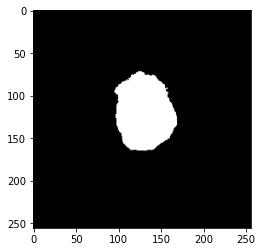

torch.Size([256, 256])
predicted


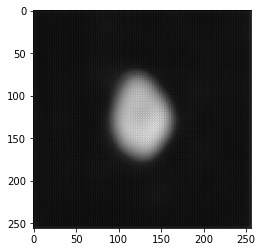

image


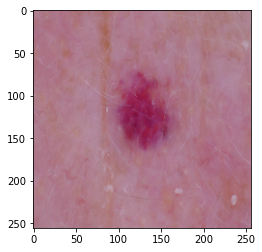

In [103]:
a = 0
b = np.random.randint(442, 443)
print(b)
for img, mask in val_ds:
    a += 1
    if a == b:
        img1 = img.unsqueeze(0).to(device)
        #rint(img1.shape)
        mask_m = model(img1)
        #rint(mask_m.shape)
        print('target')
        plt.imshow(mask.permute(1, 2, 0), cmap='gray')
        plt.show()
        mask_m = torch.squeeze(mask_m)
        print(mask_m.shape)
        mask_m = mask_m.unsqueeze(1).permute(0, 2, 1).cpu().detach().numpy()
        print('predicted')
        plt.imshow(mask_m, cmap='gray')
        plt.show()
        print('image')
        plt.imshow(img.permute(1, 2, 0))
        plt.show()
        break


In [95]:
print(img1.shape)

torch.Size([1, 3, 256, 256])


In [110]:
torch.save(model.state_dict(), 'ENET_modified.pt')

In [111]:
ENET_modified_model = ENET()
ENET_modified_model.load_state_dict(torch.load('ENET_modified.pt', map_location=torch.device('cpu')))
ENET_modified_model.eval()

ENET(
  (initial1): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (initial2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn10_1): Sequential(
    (0): Conv2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Conv2d(8, 48, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn10_2): Sequential(
    (0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv1x1_10): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (bn11): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1),

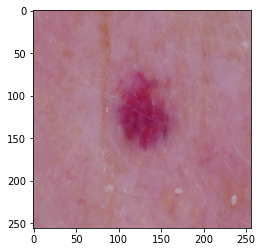

torch.Size([256, 256, 3])
torch.Size([1, 1, 256, 256])
(256, 256, 1)


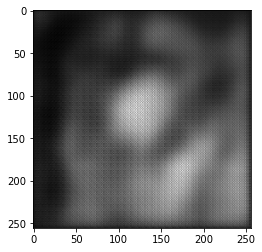

In [127]:
import os
import cv2

p1 = r"C:/Users/utkar/Desktop/ML/pytorch/image segmentation/SkinCancerDataset/test/images/ISIC_0024747.jpg"


# 24747
img = cv2.imread(p1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)
plt.show()

img = torch.tensor(img, dtype=torch.float32)
#print(img.shape)
img = img.unsqueeze(0).permute(0, 3, 1, 2)

mask = ENET_modified_model(img)
#print(mask.shape)
mask = torch.squeeze(mask).unsqueeze(0).permute(1, 2, 0).cpu().detach().numpy()
#print(mask.shape)

plt.imshow(mask, cmap='gray')
plt.show()
#mask_m = torch.squeeze(mask_m)
#mask_m = mask_m.unsqueeze(1).permute(0, 2, 1).cpu().detach().numpy()
#print('predicted')
#plt.imshow(mask_m, cmap='gray')
#plt.show()
#print('image')
#plt.imshow(img.permute(1, 2, 0))
#plt.show()
